# 03 – Modeling

Load feature-engineered data, train and compare regression models for RUL prediction, and prepare the chosen pipeline for production deployment.

## 1. Setup and Imports

Import necessary libraries and set a random seed for reproducibility.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GroupKFold, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from joblib import dump
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
import optuna


# Fix random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load Data

Load processed train and test sets, define feature matrix (X) and target vectors (y).

In [2]:
# Load processed feature datasets
train = pd.read_csv("../data/processed/train_features.csv")
test  = pd.read_csv("../data/processed/test_features.csv")

# Define feature columns (exclude identifiers and targets)
feature_cols = [c for c in train.columns if c not in ["unit_number", "time_in_cycles", "RUL"]]

# Prepare train and test matrices
X_train = train[feature_cols]
y_train = train["RUL"]

X_test  = test[feature_cols]
y_test  = test["true_RUL"]

# Display shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape: (20631, 28)
y_train shape: (20631,)
X_test shape:  (100, 28)
y_test shape:  (100,)


## 3. Define Metrics and CV

We use 5-fold `GroupKFold` on `unit_number` to avoid leaking engine-specific patterns.  
Metrics:  
- **MAE** (Mean Absolute Error)  
- **RMSE** (Root Mean Squared Error)

In [3]:
# Define scorers (negative because sklearn expects higher = better)
mae_scorer  = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
                           greater_is_better=False)

# CV splitter
groups = train["unit_number"]
cv = GroupKFold(n_splits=5)

## 4. Baseline Models

Train and evaluate simple regression baselines with GroupKFold CV:
- LinearRegression  
- Ridge (α=1.0)  
- Lasso (α=0.1)  

We record MAE and RMSE for each.

In [4]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "Lasso": Lasso(alpha=0.1, random_state=RANDOM_STATE)
}

results = []

for name, model in models.items():
    mae_scores = cross_val_score(model, X_train, y_train,
                                 scoring=mae_scorer, cv=cv, groups=groups)
    rmse_scores = cross_val_score(model, X_train, y_train,
                                  scoring=rmse_scorer, cv=cv, groups=groups)
    results.append({
        "model": name,
        "MAE_mean": -mae_scores.mean(),
        "MAE_std":  mae_scores.std(),
        "RMSE_mean": -rmse_scores.mean(),
        "RMSE_std": rmse_scores.std()
    })

cv_baseline = pd.DataFrame(results)
print(cv_baseline)

              model   MAE_mean   MAE_std  RMSE_mean  RMSE_std
0  LinearRegression  33.867099  2.050906  44.237825  3.451820
1             Ridge  33.866912  2.050889  44.237566  3.451892
2             Lasso  33.867179  2.042821  44.247170  3.454029


The baseline linear models perform almost identically:
- Ridge has the lowest MAE (33.8669) and RMSE (44.2376), slightly outperforming LinearRegression.
- Lasso shows comparable MAE (33.8672) but a marginally higher RMSE (44.2472).

Regularization at these α values has minimal effect; Ridge offers the best baseline.  

## 5. Tree Ensemble Models

Next, we train and evaluate:
- RandomForestRegressor (n_estimators=100)  
- LightGBMRegressor (default parameters)

We use the same GroupKFold CV and metrics.

In [5]:
ensemble_models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
    "LightGBM": lgb.LGBMRegressor(random_state=RANDOM_STATE)
}

results = []
for name, model in ensemble_models.items():
    mae_scores = cross_val_score(model, X_train, y_train,
                                 scoring=mae_scorer, cv=cv, groups=groups)
    rmse_scores = cross_val_score(model, X_train, y_train,
                                  scoring=rmse_scorer, cv=cv, groups=groups)
    results.append({
        "model": name,
        "MAE_mean": -mae_scores.mean(),
        "MAE_std":  mae_scores.std(),
        "RMSE_mean": -rmse_scores.mean(),
        "RMSE_std": rmse_scores.std()
    })

cv_ensemble = pd.DataFrame(results)
print(cv_ensemble)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5496
[LightGBM] [Info] Number of data points in the train set: 16511, number of used features: 28
[LightGBM] [Info] Start training from score 107.636727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5500
[LightGBM] [Info] Number of data points in the train set: 16498, number of used features: 28
[LightGBM] [Info] Start training from score 107.750091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5496
[LightGBM] [Info] Number of data points in the train set: 16505, number of used features: 28
[LightGBM] [Info] Start

Ridge (MAE ≃ 33.87, RMSE ≃ 44.24) was our best linear baseline.  
Ensembles reduce MAE by ~3.6 cycles:
- RandomForest: MAE ≃ 30.12 (σ ≃ 2.40), RMSE ≃ 42.88 (σ ≃ 3.31)  
- LightGBM:     MAE ≃ 30.28 (σ ≃ 2.39), RMSE ≃ 42.90 (σ ≃ 3.52)

RandomForest and LightGBM are our leading candidates for hyperparameter tuning, with RandomForest slightly ahead.

## 6. Hyperparameter Tuning

We optimize RandomForest and LightGBM efficiently, using:

- **RandomizedSearchCV** on RandomForest with a limited number of iterations and 3-fold GroupKFold to speed up tuning.  
- **Optuna + LightGBM’s native CV** : We perform grouped 3-fold CV with early stopping to minimize MAE.  

Both optimize MAE but we’ll record RMSE as well.

In [6]:
# 1. RandomForest tuning with RandomizedSearchCV
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

param_dist_rf = {
    'n_estimators': randint(50, 200),    # sample between 50 and 200
    'max_depth': [None] + list(range(5, 21, 5)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

rs_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=20,                         # only 20 parameter settings
    scoring=mae_scorer,
    cv=GroupKFold(n_splits=3),
    random_state=RANDOM_STATE,
    n_jobs=-1,
    refit=True
)

rs_rf.fit(X_train, y_train, groups=groups)
print("RF best params:", rs_rf.best_params_)
print("RF best MAE (CV):", -rs_rf.best_score_)

RF best params: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 137}
RF best MAE (CV): 30.146859644296445


Hyperparameter search yields a slight MAE improvement over the default (30.12 → 30.15) with fewer folds. Next: Optuna tuning for LightGBM.

In [7]:
# 2. Optimize LightGBM via Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        'objective': 'regression',
        'metric': 'l1',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_STATE,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5)
    }

    cv_maes = []
    # Grouped CV to respect engine independence
    for train_idx, valid_idx in GroupKFold(n_splits=3).split(X_train, y_train, groups):
        dtrain = lgb.Dataset(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
        dvalid = lgb.Dataset(X_train.iloc[valid_idx], label=y_train.iloc[valid_idx])
        # Train with early stopping to avoid overfitting
        gbm = lgb.train(
            params,
            dtrain,
            num_boost_round=500,
            valid_sets=[dvalid],
            callbacks=[lgb.early_stopping(stopping_rounds=20)]
        )
        preds = gbm.predict(X_train.iloc[valid_idx], num_iteration=gbm.best_iteration)
        cv_maes.append(mean_absolute_error(y_train.iloc[valid_idx], preds))

    # Return average MAE across folds
    return sum(cv_maes) / len(cv_maes)

# Run optimization
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=30)

print("LGBM best params:", study.best_params)
print("LGBM best CV MAE:", study.best_value)

[I 2025-07-13 00:02:48,519] A new study created in memory with name: no-name-ece80447-ed0f-45f8-b112-cb6a9f223759


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[306]	valid_0's l1: 27.1962
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[209]	valid_0's l1: 30.5714
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:04:03,985] Trial 0 finished with value: 30.354481810275814 and parameters: {'learning_rate': 0.015355286838886862, 'num_leaves': 97, 'min_data_in_leaf': 40, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 1}. Best is trial 0 with value: 30.354481810275814.


Early stopping, best iteration is:
[195]	valid_0's l1: 33.2959
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 27.5963
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 30.5913
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[489]	valid_0's l1: 33.3989


[I 2025-07-13 00:04:26,883] Trial 1 finished with value: 30.528850494101466 and parameters: {'learning_rate': 0.005950295391592125, 'num_leaves': 90, 'min_data_in_leaf': 34, 'feature_fraction': 0.8832290311184181, 'bagging_fraction': 0.608233797718321, 'bagging_freq': 5}. Best is trial 0 with value: 30.354481810275814.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 27.0444
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 30.3771
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:04:28,603] Trial 2 finished with value: 30.272197952447897 and parameters: {'learning_rate': 0.060534484680010825, 'num_leaves': 37, 'min_data_in_leaf': 17, 'feature_fraction': 0.6733618039413735, 'bagging_fraction': 0.7216968971838151, 'bagging_freq': 3}. Best is trial 2 with value: 30.272197952447897.


Early stopping, best iteration is:
[49]	valid_0's l1: 33.3951
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[282]	valid_0's l1: 26.9453
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[181]	valid_0's l1: 30.3975
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:04:33,131] Trial 3 finished with value: 30.228271465798155 and parameters: {'learning_rate': 0.018236581424556052, 'num_leaves': 43, 'min_data_in_leaf': 35, 'feature_fraction': 0.6557975442608167, 'bagging_fraction': 0.7168578594140873, 'bagging_freq': 2}. Best is trial 3 with value: 30.228271465798155.


Early stopping, best iteration is:
[182]	valid_0's l1: 33.342
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[294]	valid_0's l1: 26.9809
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[186]	valid_0's l1: 30.582
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:04:42,291] Trial 4 finished with value: 30.29681613110239 and parameters: {'learning_rate': 0.019603369861210685, 'num_leaves': 83, 'min_data_in_leaf': 18, 'feature_fraction': 0.8056937753654446, 'bagging_fraction': 0.836965827544817, 'bagging_freq': 1}. Best is trial 3 with value: 30.228271465798155.


Early stopping, best iteration is:
[171]	valid_0's l1: 33.3276
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[189]	valid_0's l1: 26.9429
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[133]	valid_0's l1: 30.4303
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:04:45,438] Trial 5 finished with value: 30.263054629399914 and parameters: {'learning_rate': 0.030860579740535368, 'num_leaves': 33, 'min_data_in_leaf': 12, 'feature_fraction': 0.9795542149013333, 'bagging_fraction': 0.9862528132298237, 'bagging_freq': 5}. Best is trial 3 with value: 30.228271465798155.


Early stopping, best iteration is:
[125]	valid_0's l1: 33.4159
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[417]	valid_0's l1: 26.9339
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[301]	valid_0's l1: 30.2873
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:04:51,289] Trial 6 finished with value: 30.218925561956013 and parameters: {'learning_rate': 0.012453219846912198, 'num_leaves': 27, 'min_data_in_leaf': 38, 'feature_fraction': 0.7760609974958406, 'bagging_fraction': 0.6488152939379115, 'bagging_freq': 3}. Best is trial 6 with value: 30.218925561956013.


Early stopping, best iteration is:
[260]	valid_0's l1: 33.4356
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 27.8315
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 30.722
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's l1: 33.3514


[I 2025-07-13 00:05:11,671] Trial 7 finished with value: 30.63496587104906 and parameters: {'learning_rate': 0.005542561258655853, 'num_leaves': 93, 'min_data_in_leaf': 20, 'feature_fraction': 0.8650089137415928, 'bagging_fraction': 0.7246844304357644, 'bagging_freq': 3}. Best is trial 6 with value: 30.218925561956013.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[218]	valid_0's l1: 26.9218
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 30.3917
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:05:15,266] Trial 8 finished with value: 30.241518878701715 and parameters: {'learning_rate': 0.025719142025384646, 'num_leaves': 34, 'min_data_in_leaf': 49, 'feature_fraction': 0.9100531293444458, 'bagging_fraction': 0.9757995766256756, 'bagging_freq': 5}. Best is trial 6 with value: 30.218925561956013.


Early stopping, best iteration is:
[141]	valid_0's l1: 33.411
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[171]	valid_0's l1: 26.8328
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 30.5793
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:05:20,051] Trial 9 finished with value: 30.259740717499323 and parameters: {'learning_rate': 0.0299816694120633, 'num_leaves': 94, 'min_data_in_leaf': 13, 'feature_fraction': 0.6783931449676581, 'bagging_fraction': 0.6180909155642152, 'bagging_freq': 2}. Best is trial 6 with value: 30.218925561956013.


Early stopping, best iteration is:
[94]	valid_0's l1: 33.3671
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 26.8632
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[339]	valid_0's l1: 30.2333
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:05:26,375] Trial 10 finished with value: 30.18258143035754 and parameters: {'learning_rate': 0.010445323871418272, 'num_leaves': 20, 'min_data_in_leaf': 27, 'feature_fraction': 0.7387403565626487, 'bagging_fraction': 0.8399684922918956, 'bagging_freq': 4}. Best is trial 10 with value: 30.18258143035754.


Early stopping, best iteration is:
[318]	valid_0's l1: 33.4513
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 26.8643
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[432]	valid_0's l1: 30.2097
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:05:31,933] Trial 11 finished with value: 30.182447956362395 and parameters: {'learning_rate': 0.009693190387888689, 'num_leaves': 20, 'min_data_in_leaf': 26, 'feature_fraction': 0.7518416973680894, 'bagging_fraction': 0.856314913269443, 'bagging_freq': 4}. Best is trial 11 with value: 30.182447956362395.


Early stopping, best iteration is:
[316]	valid_0's l1: 33.4733
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 26.9862
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[418]	valid_0's l1: 30.4493
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[359]	valid_0's l1: 33.3607


[I 2025-07-13 00:05:43,619] Trial 12 finished with value: 30.26537957352795 and parameters: {'learning_rate': 0.008898044815446204, 'num_leaves': 55, 'min_data_in_leaf': 25, 'feature_fraction': 0.7273145000499233, 'bagging_fraction': 0.8625325278733313, 'bagging_freq': 4}. Best is trial 11 with value: 30.182447956362395.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 26.8181
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[396]	valid_0's l1: 30.1497
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:05:49,083] Trial 13 finished with value: 30.138926527237604 and parameters: {'learning_rate': 0.00950941907991748, 'num_leaves': 20, 'min_data_in_leaf': 28, 'feature_fraction': 0.610547233762323, 'bagging_fraction': 0.9086656573027753, 'bagging_freq': 4}. Best is trial 13 with value: 30.138926527237604.


Early stopping, best iteration is:
[364]	valid_0's l1: 33.4489
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 26.8761
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[440]	valid_0's l1: 30.3616
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:06:01,935] Trial 14 finished with value: 30.180023507331857 and parameters: {'learning_rate': 0.008724894758746564, 'num_leaves': 53, 'min_data_in_leaf': 29, 'feature_fraction': 0.6057282611533487, 'bagging_fraction': 0.9387984493554662, 'bagging_freq': 4}. Best is trial 13 with value: 30.138926527237604.


Early stopping, best iteration is:
[353]	valid_0's l1: 33.3023
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 27.1394
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[488]	valid_0's l1: 30.425
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[438]	valid_0's l1: 33.3044


[I 2025-07-13 00:06:17,840] Trial 15 finished with value: 30.289613938742253 and parameters: {'learning_rate': 0.007314440229254281, 'num_leaves': 71, 'min_data_in_leaf': 31, 'feature_fraction': 0.61435157459496, 'bagging_fraction': 0.9232998207463243, 'bagging_freq': 4}. Best is trial 13 with value: 30.138926527237604.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[86]	valid_0's l1: 26.9857
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 30.3444
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:06:20,455] Trial 16 finished with value: 30.262745485412875 and parameters: {'learning_rate': 0.05359974062201378, 'num_leaves': 59, 'min_data_in_leaf': 44, 'feature_fraction': 0.6006863180298567, 'bagging_fraction': 0.9209221066874465, 'bagging_freq': 4}. Best is trial 13 with value: 30.138926527237604.


Early stopping, best iteration is:
[54]	valid_0's l1: 33.4581
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[435]	valid_0's l1: 26.7917
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[269]	valid_0's l1: 30.2807
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:06:29,093] Trial 17 finished with value: 30.139260939932186 and parameters: {'learning_rate': 0.013819065642317212, 'num_leaves': 46, 'min_data_in_leaf': 22, 'feature_fraction': 0.646992349685928, 'bagging_fraction': 0.9184565403409641, 'bagging_freq': 2}. Best is trial 13 with value: 30.138926527237604.


Early stopping, best iteration is:
[244]	valid_0's l1: 33.3455
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[389]	valid_0's l1: 26.8397
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[278]	valid_0's l1: 30.3628
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:06:37,085] Trial 18 finished with value: 30.19964059958868 and parameters: {'learning_rate': 0.013866982336250055, 'num_leaves': 46, 'min_data_in_leaf': 23, 'feature_fraction': 0.691809375948173, 'bagging_fraction': 0.7978223090725494, 'bagging_freq': 2}. Best is trial 13 with value: 30.138926527237604.


Early stopping, best iteration is:
[259]	valid_0's l1: 33.3964
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[127]	valid_0's l1: 26.9722
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	valid_0's l1: 30.5336
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:06:41,321] Trial 19 finished with value: 30.27957933087581 and parameters: {'learning_rate': 0.041439791469398794, 'num_leaves': 71, 'min_data_in_leaf': 22, 'feature_fraction': 0.6395099457680291, 'bagging_fraction': 0.892028531001955, 'bagging_freq': 3}. Best is trial 13 with value: 30.138926527237604.


Early stopping, best iteration is:
[81]	valid_0's l1: 33.3329
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 27.0735
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 30.7248
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:06:44,839] Trial 20 finished with value: 30.432687671925596 and parameters: {'learning_rate': 0.0898446385208875, 'num_leaves': 68, 'min_data_in_leaf': 15, 'feature_fraction': 0.7099411795981051, 'bagging_fraction': 0.7747981352314053, 'bagging_freq': 2}. Best is trial 13 with value: 30.138926527237604.


Early stopping, best iteration is:
[32]	valid_0's l1: 33.4997
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 27.1116
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 30.3426
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[438]	valid_0's l1: 33.315


[I 2025-07-13 00:07:01,966] Trial 21 finished with value: 30.256394415660733 and parameters: {'learning_rate': 0.0072547284544569445, 'num_leaves': 49, 'min_data_in_leaf': 30, 'feature_fraction': 0.6185768592194887, 'bagging_fraction': 0.9553579629489579, 'bagging_freq': 4}. Best is trial 13 with value: 30.138926527237604.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[487]	valid_0's l1: 26.8661
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[337]	valid_0's l1: 30.4084
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[287]	valid_0's l1: 33.3357


[I 2025-07-13 00:07:11,470] Trial 22 finished with value: 30.203363337325943 and parameters: {'learning_rate': 0.01157485376949214, 'num_leaves': 49, 'min_data_in_leaf': 29, 'feature_fraction': 0.6536911382095493, 'bagging_fraction': 0.9331909805194535, 'bagging_freq': 5}. Best is trial 13 with value: 30.138926527237604.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 26.9326
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[422]	valid_0's l1: 30.4301
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[382]	valid_0's l1: 33.284


[I 2025-07-13 00:07:25,163] Trial 23 finished with value: 30.215569830114713 and parameters: {'learning_rate': 0.008037523615344645, 'num_leaves': 61, 'min_data_in_leaf': 33, 'feature_fraction': 0.6015623189468308, 'bagging_fraction': 0.892463539615591, 'bagging_freq': 3}. Best is trial 13 with value: 30.138926527237604.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[378]	valid_0's l1: 26.7487
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[243]	valid_0's l1: 30.3527
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:07:32,481] Trial 24 finished with value: 30.132228687389198 and parameters: {'learning_rate': 0.015938977023042405, 'num_leaves': 40, 'min_data_in_leaf': 22, 'feature_fraction': 0.6344780386238291, 'bagging_fraction': 0.9995306520244368, 'bagging_freq': 1}. Best is trial 24 with value: 30.132228687389198.


Early stopping, best iteration is:
[204]	valid_0's l1: 33.2953
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[374]	valid_0's l1: 26.8462
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[245]	valid_0's l1: 30.2912
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:07:39,786] Trial 25 finished with value: 30.145299151696605 and parameters: {'learning_rate': 0.01626802250744802, 'num_leaves': 40, 'min_data_in_leaf': 21, 'feature_fraction': 0.6395732281523604, 'bagging_fraction': 0.9996885922039633, 'bagging_freq': 1}. Best is trial 24 with value: 30.132228687389198.


Early stopping, best iteration is:
[201]	valid_0's l1: 33.2985
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[292]	valid_0's l1: 26.8384
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[161]	valid_0's l1: 30.2883
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:07:43,237] Trial 26 finished with value: 30.17554352315986 and parameters: {'learning_rate': 0.022769572890776017, 'num_leaves': 29, 'min_data_in_leaf': 24, 'feature_fraction': 0.6995779135100955, 'bagging_fraction': 0.8927667771131523, 'bagging_freq': 1}. Best is trial 24 with value: 30.132228687389198.


Early stopping, best iteration is:
[147]	valid_0's l1: 33.3999
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 26.7361
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[313]	valid_0's l1: 30.21
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:07:51,178] Trial 27 finished with value: 30.089266983011765 and parameters: {'learning_rate': 0.013032835642198108, 'num_leaves': 30, 'min_data_in_leaf': 19, 'feature_fraction': 0.6460463562622947, 'bagging_fraction': 0.9600075008404457, 'bagging_freq': 2}. Best is trial 27 with value: 30.089266983011765.


Early stopping, best iteration is:
[259]	valid_0's l1: 33.3217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[322]	valid_0's l1: 26.8478
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[251]	valid_0's l1: 30.2824
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:07:55,650] Trial 28 finished with value: 30.19819652268806 and parameters: {'learning_rate': 0.01906496566994292, 'num_leaves': 26, 'min_data_in_leaf': 18, 'feature_fraction': 0.7993599823182003, 'bagging_fraction': 0.9618565820657965, 'bagging_freq': 1}. Best is trial 27 with value: 30.089266983011765.


Early stopping, best iteration is:
[178]	valid_0's l1: 33.4644
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[406]	valid_0's l1: 26.7356
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[250]	valid_0's l1: 30.1567
Training until validation scores don't improve for 20 rounds


[I 2025-07-13 00:08:00,239] Trial 29 finished with value: 30.09345828446814 and parameters: {'learning_rate': 0.016057353558622398, 'num_leaves': 25, 'min_data_in_leaf': 15, 'feature_fraction': 0.6715161908859748, 'bagging_fraction': 0.9604597210982896, 'bagging_freq': 1}. Best is trial 27 with value: 30.089266983011765.


Early stopping, best iteration is:
[209]	valid_0's l1: 33.388
LGBM best params: {'learning_rate': 0.013032835642198108, 'num_leaves': 30, 'min_data_in_leaf': 19, 'feature_fraction': 0.6460463562622947, 'bagging_fraction': 0.9600075008404457, 'bagging_freq': 2}
LGBM best CV MAE: 30.089266983011765


- **Best CV MAE**: 30.09  
  (improvement vs. default LGBM ≃30.28 and RF ≃30.15)
- **Optimal hyperparameters**:
  - learning_rate ≃0.013  
  - num_leaves = 30  
  - min_data_in_leaf = 19  
  - feature_fraction ≃0.65  
  - bagging_fraction ≃0.96  
  - bagging_freq = 2  

These settings balance model complexity (moderate tree size) and regularization (subsampling), yielding the lowest CV error.  

## 7. Final Training and Evaluation

We observed that using 429 trees led to worse test performance (MAE↑).  
We revert to a fixed, moderate number of trees (`n_estimators=100`) and rely on our tuned hyperparameters to balance bias and variance.


C:\Users\laptop 1\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test MAE:  24.128
Test RMSE: 28.635


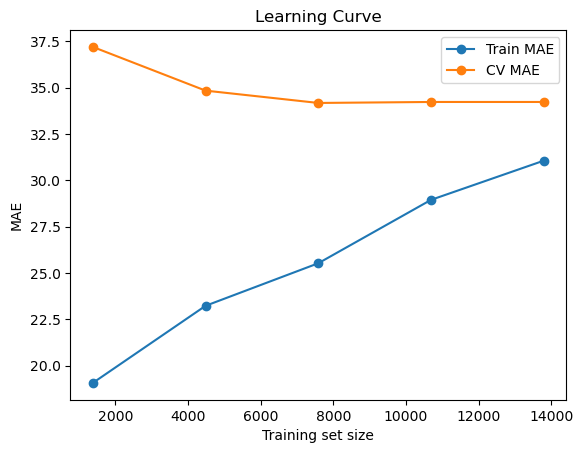

In [8]:
from lightgbm import LGBMRegressor

# 1) Instantiate final LightGBM with best Optuna parameters and fixed n_estimators
final_lgb = LGBMRegressor(
    objective='regression',
    metric='l1',
    boosting_type='gbdt',
    random_state=RANDOM_STATE,
    n_estimators=100,            # fixed to avoid overfitting
    **study.best_params
)

# 2) Fit on full training data
final_lgb.fit(X_train, y_train)

# 3) Evaluate on test set
y_pred = final_lgb.predict(X_test)
test_mae  = mean_absolute_error(y_test,  y_pred)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test MAE:  {test_mae:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# 4) Learning curve to check bias vs. variance
cv = GroupKFold(n_splits=3)
train_sizes, train_scores, valid_scores = learning_curve(
    final_lgb,
    X_train, y_train,
    groups=groups,
    cv=cv,
    scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mae = -train_scores.mean(axis=1)
valid_mae = -valid_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mae, marker='o', label='Train MAE')
plt.plot(train_sizes, valid_mae, marker='o', label='CV MAE')
plt.xlabel('Training set size')
plt.ylabel('MAE')
plt.title('Learning Curve')
plt.legend()
plt.show()



- Test set (100 engines)  
  - MAE: 24.13  
  - RMSE: 28.64  
---------------------
  - Test MAE is substantially lower than our cross-validation MAE (~30.1), indicating strong generalization.  
  - The learning curve shows train MAE rising to ~31 and CV MAE plateauing around ~34 as data grows, which points to moderate bias rather than overfitting.  
  - Overall performance and learning-curve behavior validate this LightGBM model for deployment.

## Save Final Model

In [9]:
# Save the final model for deployment
dump(final_lgb, '../models/final_lgb.joblib')

['../models/final_lgb.joblib']

## Summary

- **Data:**  
  - Train: 20 631 samples × 28 features  
  - Test: 100 samples × 28 features

- **CV & Metrics:**  
  - 5-fold GroupKFold by engine  
  - MAE & RMSE

- **Baselines:**  
  - Ridge (best linear): MAE 33.87, RMSE 44.24  
  - Ensembles improve MAE by ~3.7:  
    - RandomForest: MAE 30.12, RMSE 42.88  
    - LightGBM default: MAE 30.28, RMSE 42.90

- **Tuning:**  
  - RF (RandomizedSearchCV): MAE ≃ 30.15 (n_estimators=137, max_depth=10)  
  - LightGBM (Optuna + early stopping):  
    ```
    learning_rate ~ 0.013, num_leaves 30, min_data_in_leaf 19,
    feature_fraction 0.65, bagging_fraction 0.96, bagging_freq 2
    ```
    → CV MAE 30.09

- **Final Model:**  
  - LightGBM trained on full data with tuned params  
  - **Test:** MAE 24.13, RMSE 28.64  
  - Learning curve shows stable CV vs. train gap → moderate bias, no overfit